### Download the MLPerf results:

In [1]:
!git clone --depth 1 https://github.com/mlperf/training_results_v0.7

fatal: destination path 'training_results_v0.7' already exists and is not an empty directory.


In [2]:
import glob
import json
from collections import defaultdict, OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
%config InlineBackend.figure_format = 'retina'
style.use('fivethirtyeight')

class ResultsParser(object):
    def __init__(self, directory):
        self.directory = directory
        self.mllog = {}
        mllog_values = defaultdict(list)
        
        files = glob.glob(f"training_results_v0.7/{self.directory}/*.txt")
        for file_path in files:
            lines = [line.rstrip('\n') for line in open(file_path)]
            for line in lines:
                self.result_mllog = defaultdict(list)
                if ":::MLLOG" in line:
                    mllog_checkpoint = json.loads(line.split(":::MLLOG")[1])
                    mllog_values[mllog_checkpoint["key"]].append(int(mllog_checkpoint["time_ms"]))
            # lazy, do just take one results file and be done
        for key, values in mllog_values.items():
            self.mllog[key] = np.median(values)
            
    def get_full_results(self):
        return self.mllog
    
    def calculate_duration_seconds(self, start_ms, stop_ms, round_to=1):
        return round((stop_ms-start_ms)/1000, round_to)
    
    def get_init_duration(self):
        init_start = self.mllog["init_start"]
        init_stop = self.mllog["init_stop"]
        return self.calculate_duration_seconds(init_start, init_stop)
    
    def get_train_run_duration(self):
        run_start = self.mllog["run_start"]
        run_stop = self.mllog["run_stop"]
        return self.calculate_duration_seconds(run_start, run_stop)
    
    def get_full_duration(self):
        return self.get_init_duration() + self.get_train_run_duration()
    
    def get_report(self):
        print("Time Taken (seconds)")
        print("====================")
        print(" Init:", self.get_init_duration())
        print("  Run:", self.get_train_run_duration())
        print("Total:", self.get_full_duration())
        print("====================")
        print("Results dir:")
        print(self.directory)

## BERT

NVIDIA A100 vs Google TPU

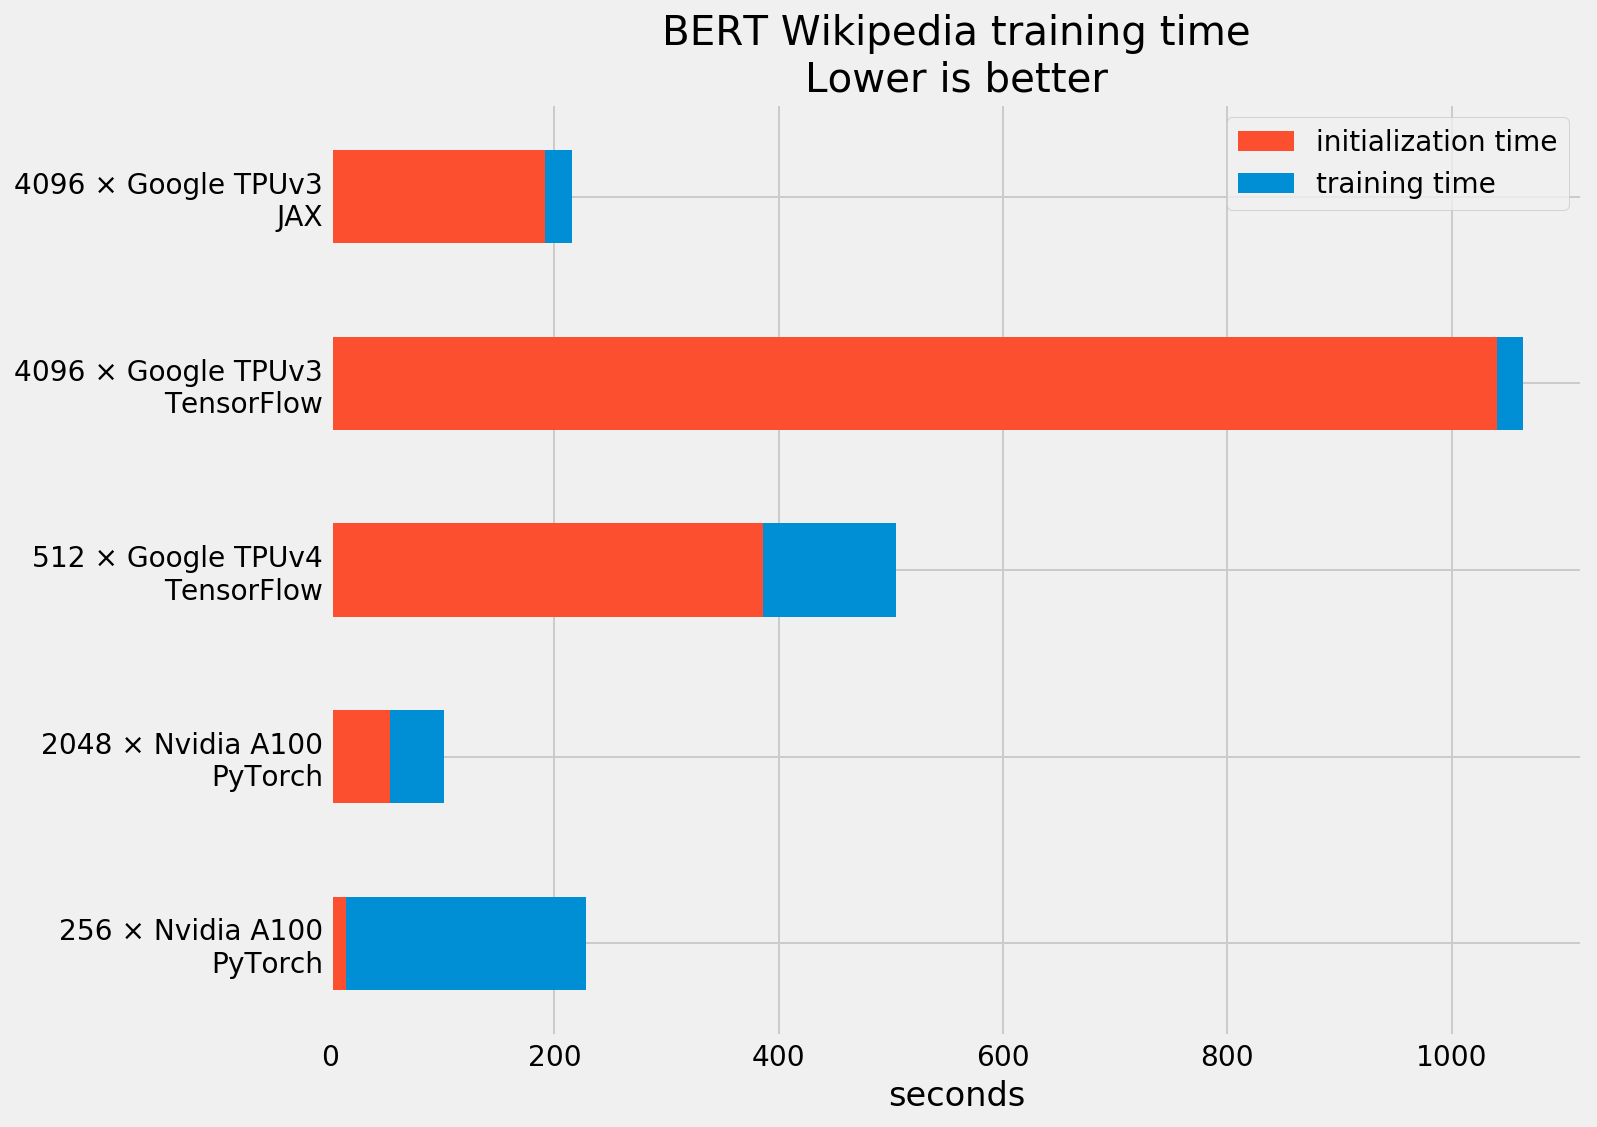

In [3]:
bert_results = OrderedDict({
    "256 × Nvidia A100\nPyTorch": ResultsParser("NVIDIA/results/dgxa100_n32_ngc20.06_pytorch/bert"),
    "2048 × Nvidia A100\nPyTorch": ResultsParser("NVIDIA/results/dgxa100_n256_ngc20.06_pytorch/bert"),
    "512 × Google TPUv4\nTensorFlow": ResultsParser("Google/results/tpu-v4-512-TF/bert"),
    "4096 × Google TPUv3\nTensorFlow": ResultsParser("Google/results/tpu-v3-8192-TF/bert"),
    "4096 × Google TPUv3\nJAX": ResultsParser("Google/results/tpu-v3-8192-JAX/bert"),
})

plotdata = pd.DataFrame({
    "initialization time": [res.get_init_duration() for res in bert_results.values()],
    "training time": [res.get_train_run_duration() for res in bert_results.values()],
    }, 
    index=bert_results.keys()
)
plot_title = "BERT Wikipedia training time\n" + \
             "Lower is better"
plotdata.plot(kind="barh", title=plot_title, stacked=True, figsize=(10,8),
    color = [
        '#fc4f30',
        '#008fd5',
    ])
plt.xlabel('seconds')
plt.show()

## Transformer (translation, non-recurrent benchmark)

NVIDIA A100 vs Google TPU

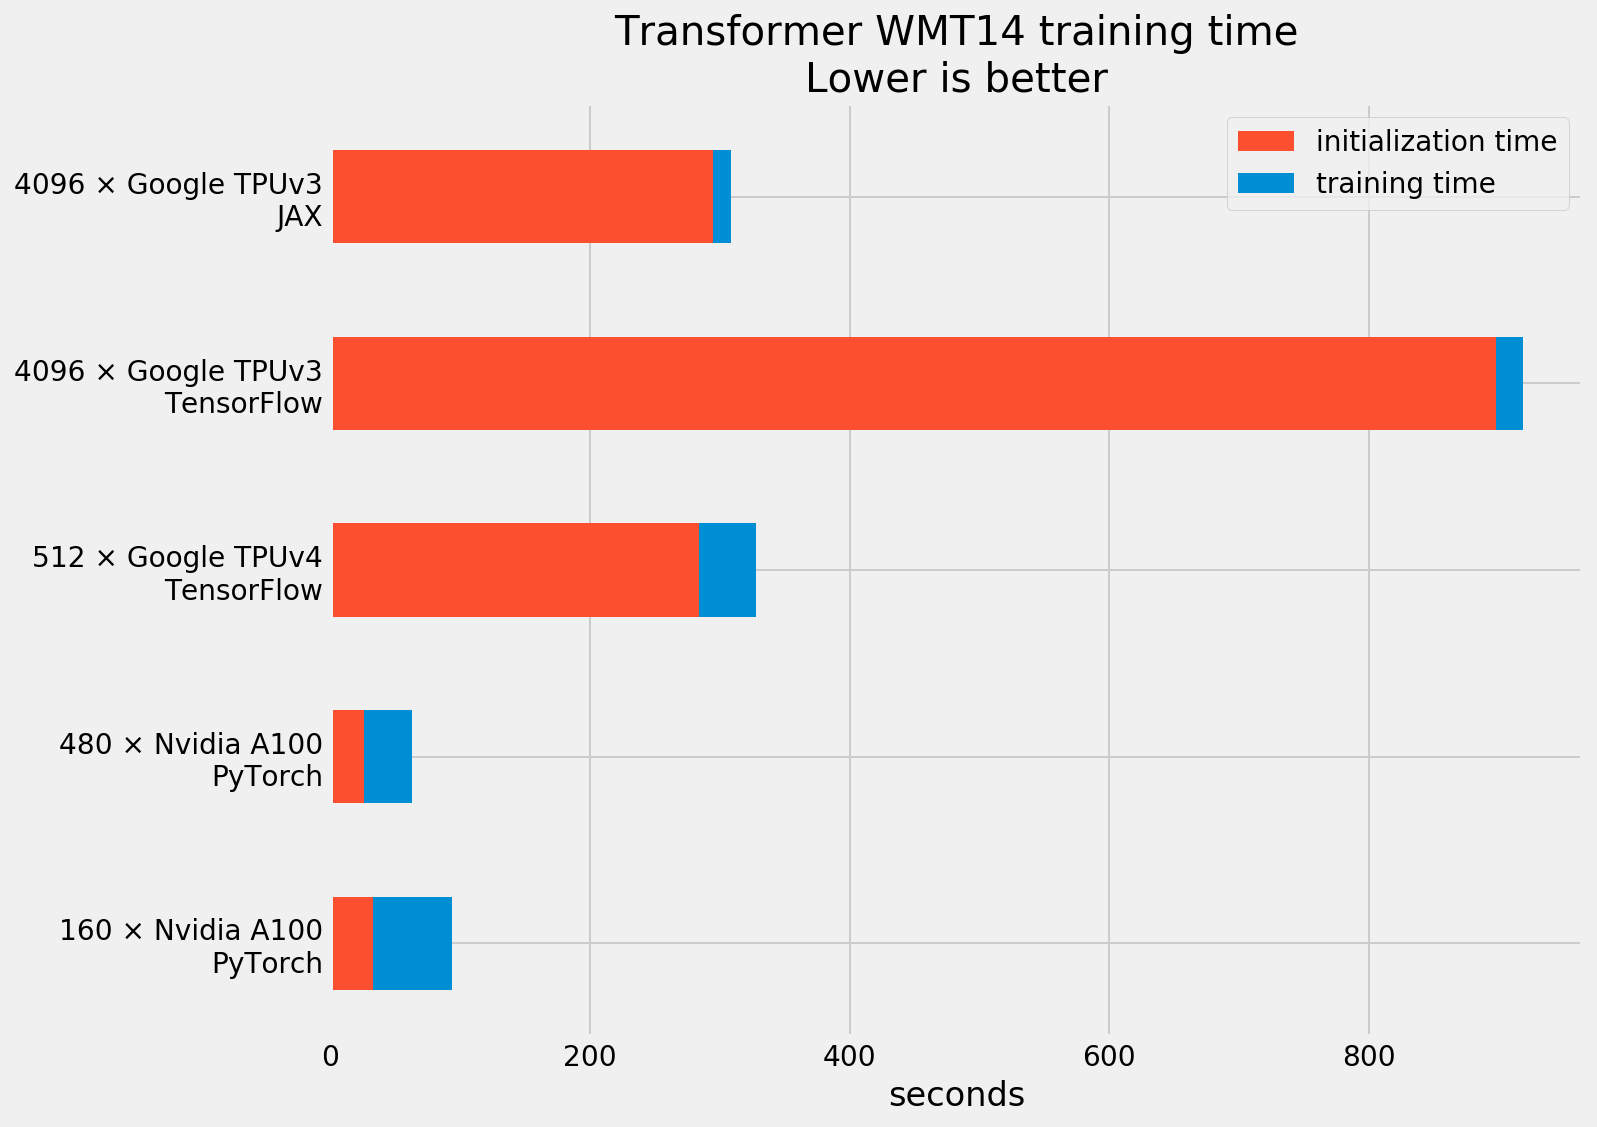

In [4]:
bert_results = OrderedDict({
    "160 × Nvidia A100\nPyTorch": ResultsParser("NVIDIA/results/dgxa100_n20_ngc20.06_pytorch/transformer"),
    "480 × Nvidia A100\nPyTorch": ResultsParser("NVIDIA/results/dgxa100_n60_ngc20.06_pytorch/transformer"),
    "512 × Google TPUv4\nTensorFlow": ResultsParser("Google/results/tpu-v4-512-TF/transformer"),
    "4096 × Google TPUv3\nTensorFlow": ResultsParser("Google/results/tpu-v3-8192-TF/transformer"),
    "4096 × Google TPUv3\nJAX": ResultsParser("Google/results/tpu-v3-8192-JAX/transformer"),
})

plotdata = pd.DataFrame({
    "initialization time": [res.get_init_duration() for res in bert_results.values()],
    "training time": [res.get_train_run_duration() for res in bert_results.values()],
    }, 
    index=bert_results.keys()
)
plot_title = "Transformer WMT14 training time\n" + \
             "Lower is better"
plotdata.plot(kind="barh", title=plot_title, stacked=True, figsize=(10,8),
    color = [
        '#fc4f30',
        '#008fd5',
    ])
plt.xlabel('seconds')
plt.xlabel('seconds')
plt.show()